# Geographic Data Science with Python - Report 7

---

## Section 1: Summary of Readings

# Chapter 11: Spatial Regression

## Overview
Spatial regression extends traditional regression by accounting for **spatial effects**—important when nearby locations influence outcomes or when geography introduces bias.

## Dataset
- **Source**: Airbnb listings in San Diego  
- **Variables**: Price (log), # beds, # baths, property type, distance to Balboa Park, neighborhood

## Ordinary Least Squares (OLS)
- Baseline model predicts log-price.
- Residuals show **spatial clustering** → violates OLS assumptions.
- Moran's I confirms spatial autocorrelation in residuals.

## Adding Spatial Effects

### 1. Spatial Feature Engineering
- Add spatial proxies (e.g. `distance to Balboa Park`)
- Little improvement; residual clustering remains

### 2. Spatial Heterogeneity
- **Fixed effects**: Add dummy variables for neighborhoods
- **Spatial regimes**: Allow slopes to vary by region

### 3. Spatial Dependence
- **SLX (Spatial Lag of X)**: Include spatially lagged predictors
- **Spatial error model**: Errors depend on neighboring errors (λ significant)
- **Spatial lag model**: Includes lagged dependent variable (ρ * Wy)

## Key Concepts
- **Heterogeneity**: Geography alters model structure
- **Dependence**: Nearby values influence each other
- **Feature engineering**: Add spatial info to classic models


## Section 2: Working With Python

In [72]:
from pysal.lib import weights
from pysal.explore import esda
import numpy
import pandas
import geopandas
import matplotlib.pyplot as plt
import seaborn
import contextily

### Data: San Diego Airbnb

In [73]:
data_root = "C:/Users/riley/Desktop/book/"
db = geopandas.read_file(data_root + "data/airbnb/regression_db.geojson")

In [74]:
variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

In [75]:
from pysal.model import spreg

In [76]:
# Fit OLS model
m1 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Dependent variable name
    name_y="log_price",
    # Independent variable name
    name_x=variable_names,
)

In [77]:
print(m1.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:     1320.15                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

------------------------------------------------------------

### Hidden structures

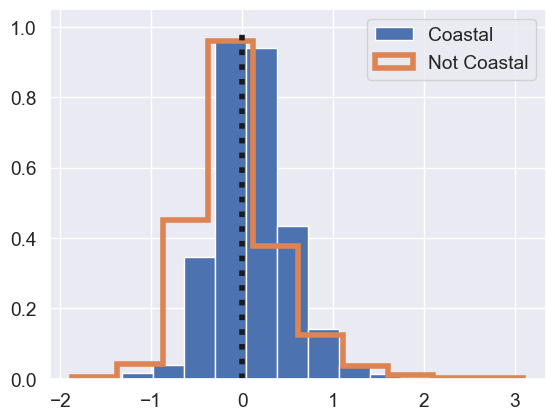

In [78]:
# Create a Boolean (True/False) with whether a
# property is coastal or not
is_coastal = db.coastal.astype(bool)
# Split residuals (m1.u) between coastal and not
coastal = m1.u[is_coastal]
not_coastal = m1.u[~is_coastal]
# Create histogram of the distribution of coastal residuals
plt.hist(coastal, density=True, label="Coastal")
# Create histogram of the distribution of non-coastal residuals
plt.hist(
    not_coastal,
    histtype="step",
    density=True,
    linewidth=4,
    label="Not Coastal",
)
# Add Line on 0
plt.vlines(0, 0, 1, linestyle=":", color="k", linewidth=4)
# Add legend
plt.legend()
# Display
plt.show()

In [79]:
from scipy.stats import ttest_ind

ttest_ind(coastal, not_coastal)

TtestResult(statistic=array([13.98193858]), pvalue=array([9.442438e-44]), df=array([6108.]))

C:\Users\riley\AppData\Local\Temp\ipykernel_4728\4009308338.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  seaborn.boxplot(


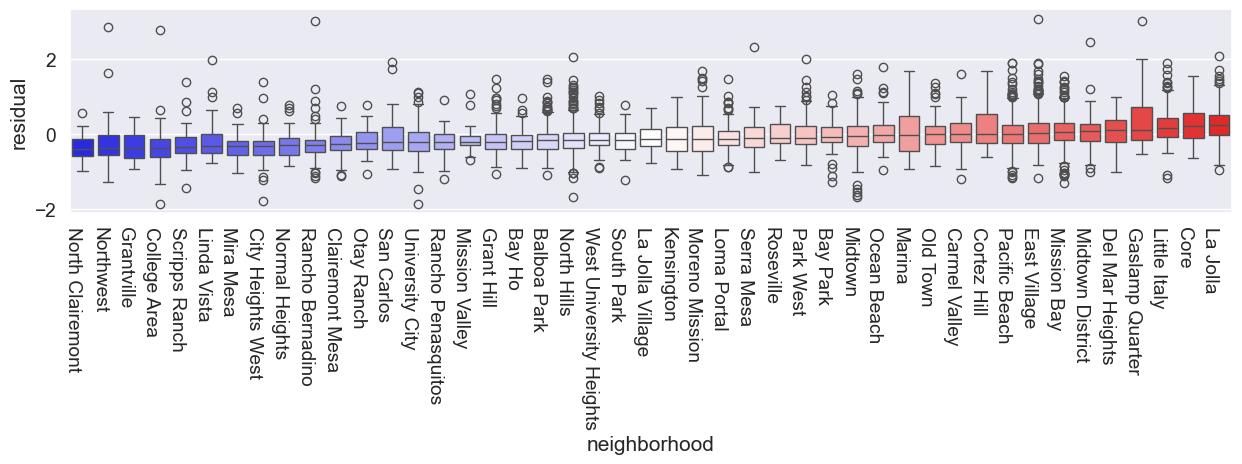

In [80]:
# Create column with residual values from m1
db["residual"] = m1.u
# Obtain the median value of residuals in each neighborhood
medians = (
    db.groupby("neighborhood")
    .residual.median()
    .to_frame("hood_residual")
)

# Increase fontsize
seaborn.set(font_scale=1.25)
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()
# Generate bloxplot of values by neighborhood
# Note the data includes the median values merged on-the-fly
seaborn.boxplot(
    x="neighborhood",
    y="residual",
    ax=ax,
    data=db.merge(
        medians, how="left", left_on="neighborhood", right_index=True
    ).sort_values("hood_residual"),
    palette="bwr",
)
# Rotate the X labels for legibility
f.autofmt_xdate(rotation=-90)
# Display
plt.show()

In [81]:
knn = weights.KNN.from_dataframe(db, k=1)

c:\Users\riley\repos\GIS-independent-study\.venv\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 1849 disconnected components.
  warnings.warn(message)


Text(0, 0.5, 'Spatial Lag of Model Residuals - $W u$')

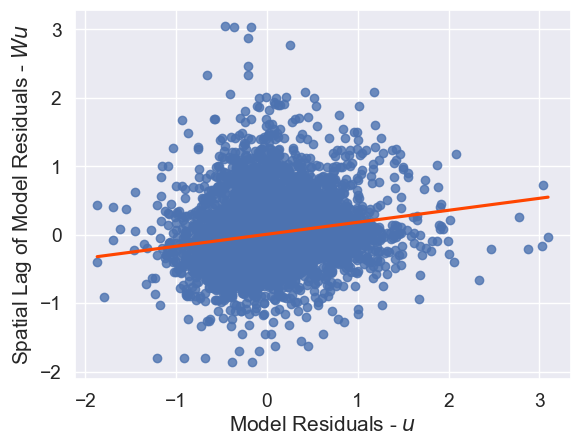

In [82]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m1.u)
ax = seaborn.regplot(
    x=m1.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Model Residuals - $u$")
ax.set_ylabel("Spatial Lag of Model Residuals - $W u$")

c:\Users\riley\repos\GIS-independent-study\.venv\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


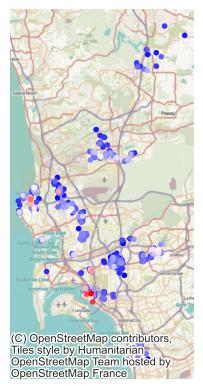

In [83]:
# Re-weight W to 20 nearest neighbors
knn.reweight(k=20, inplace=True)
# Row standardize weights
knn.transform = "R"
# Run LISA on residuals
outliers = esda.moran.Moran_Local(m1.u, knn, permutations=9999)
# Select only LISA cluster cores
error_clusters = outliers.q % 2 == 1
# Filter out non-significant clusters
error_clusters &= outliers.p_sim <= 0.001
# Add `error_clusters` and `local_I` columns
ax = (
    db.assign(
        error_clusters=error_clusters,
        local_I=outliers.Is
        # Retain error clusters only
    )
    .query(
        "error_clusters"
        # Sort by I value to largest plot on top
    )
    .sort_values(
        "local_I"
        # Plot I values
    )
    .plot("local_I", cmap="bwr", marker=".")
)
# Add basemap
contextily.add_basemap(ax, crs=db.crs)
# Remove axes
ax.set_axis_off()

### Spatial feature engineering: proximity variables

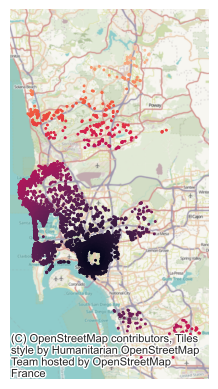

In [84]:
ax = db.plot("d2balboa", marker=".", s=5)
contextily.add_basemap(ax, crs=db.crs)
ax.set_axis_off()

In [85]:
balboa_names = variable_names + ["d2balboa"]

In [86]:
m2 = spreg.OLS(
    db[["log_price"]].values,
    db[balboa_names].values,
    name_y="log_price",
    name_x=balboa_names,
)

In [87]:
pandas.DataFrame(
    [[m1.r2, m1.ar2], [m2.r2, m2.ar2]],
    index=["M1", "M2"],
    columns=["R2", "Adj. R2"],
)

,R2,Adj. R2
M1,0.668345,0.667801
M2,0.668502,0.667904


In [88]:
# Set up table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m2.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m2.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m2.t_stat],
    },
    index=m2.name_x,
)

,Coeff.,Std. Error,P-Value
CONSTANT,4.379624,0.016915,0.000000e+00
accommodates,0.083644,0.005079,1.156896e-59
bathrooms,0.190791,0.011005,9.120139e-66
bedrooms,0.150746,0.011179,7.418035e-41
beds,-0.041476,0.006939,2.394322e-09
rt_Private_room,-0.552996,0.015960,2.680270e-240
rt_Shared_room,-1.235521,0.038462,2.586867e-209
pg_Condominium,0.140459,0.022225,2.803765e-10
pg_House,-0.013302,0.014623,3.630396e-01
pg_Other,0.141176,0.022798,6.309880e-10


Text(0, 0.5, 'Spatial lag of residuals ($Wu$)')

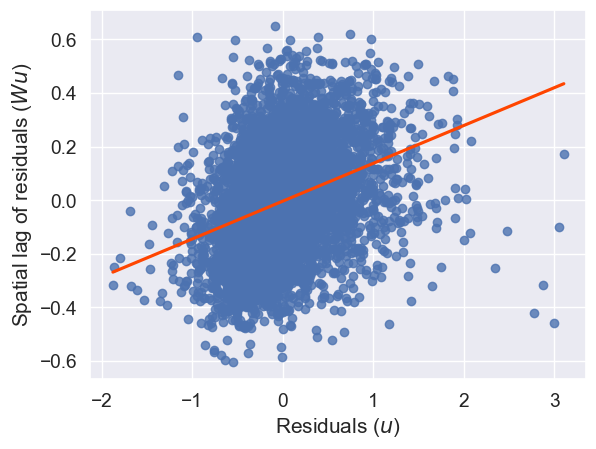

In [89]:
lag_residual = weights.spatial_lag.lag_spatial(knn, m2.u)
ax = seaborn.regplot(
    x=m2.u.flatten(),
    y=lag_residual.flatten(),
    line_kws=dict(color="orangered"),
    ci=None,
)
ax.set_xlabel("Residuals ($u$)")
ax.set_ylabel("Spatial lag of residuals ($Wu$)")

### Spatial heterogeneity

In [90]:
import statsmodels.formula.api as sm

In [91]:
f = (
    "log_price ~ "
    + " + ".join(variable_names)
    + " + neighborhood - 1"
)
print(f)

log_price ~ accommodates + bathrooms + bedrooms + beds + rt_Private_room + rt_Shared_room + pg_Condominium + pg_House + pg_Other + pg_Townhouse + neighborhood - 1


In [92]:
m3 = sm.ols(f, data=db).fit()

In [93]:
# Store variable names for all the spatial fixed effects
sfe_names = [i for i in m3.params.index if "neighborhood[" in i]
# Create table
pandas.DataFrame(
    {
        "Coef.": m3.params[sfe_names],
        "Std. Error": m3.bse[sfe_names],
        "P-Value": m3.pvalues[sfe_names],
    }
)

,Coef.,Std. Error,P-Value
neighborhood[Balboa Park],4.280766,0.033292,0.0
neighborhood[Bay Ho],4.198251,0.076878,0.0
neighborhood[Bay Park],4.329223,0.050987,0.0
neighborhood[Carmel Valley],4.389261,0.056553,0.0
neighborhood[City Heights West],4.053518,0.058378,0.0
neighborhood[Clairemont Mesa],4.095259,0.047699,0.0
neighborhood[College Area],4.033697,0.058258,0.0
neighborhood[Core],4.726186,0.052643,0.0
neighborhood[Cortez Hill],4.608090,0.051526,0.0
neighborhood[Del Mar Heights],4.496910,0.054337,0.0


In [94]:
# spreg spatial fixed effect implementation
m4 = spreg.OLS_Regimes(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Variable specifying neighborhood membership
    db["neighborhood"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False] * len(variable_names),
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

c:\Users\riley\repos\GIS-independent-study\.venv\lib\site-packages\spreg\diagnostics.py:620: ComplexWarning: Casting complex values to real discards the imaginary part
  ci_result = sqrt(max_eigval / min_eigval)


In [95]:
import numpy

numpy.round(m4.betas.flatten() - m3.params.values, decimals=12)

array([-0.e+00, -1.e-12,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00,
        0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00, -0.e+00,  0.e+00,
       -0.e+00, -0.e+00,  0.e+00,  0.e+00,  0.e+00,  0.e+00])

In [96]:
neighborhood_effects = m3.params.filter(like="neighborhood")
neighborhood_effects.head()

neighborhood[Balboa Park]          4.280766
neighborhood[Bay Ho]               4.198251
neighborhood[Bay Park]             4.329223
neighborhood[Carmel Valley]        4.389261
neighborhood[City Heights West]    4.053518
dtype: float64

In [97]:
# Create a sequence with the variable names without
# `neighborhood[` and `]`
stripped = neighborhood_effects.index.str.strip(
    "neighborhood["
).str.strip("]")
# Reindex the neighborhood_effects Series on clean names
neighborhood_effects.index = stripped
# Convert Series to DataFrame
neighborhood_effects = neighborhood_effects.to_frame("fixed_effect")
# Print top of table
neighborhood_effects.head()

,fixed_effect
Balboa Park,4.280766
Bay Ho,4.198251
Bay Park,4.329223
Carmel Valley,4.389261
City Heights West,4.053518


In [98]:
sd_path = data_root + "/data/airbnb/neighbourhoods.geojson"
neighborhoods = geopandas.read_file(sd_path)

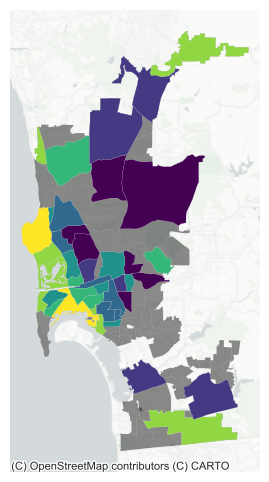

In [99]:
# Plot base layer with all neighborhoods in grey
ax = neighborhoods.plot(
    color="k", linewidth=0, alpha=0.5, figsize=(12, 6)
)
# Merge SFE estimates (note not every polygon
# receives an estimate since not every polygon
# contains Airbnb properties)
neighborhoods.merge(
    neighborhood_effects,
    how="left",
    left_on="neighbourhood",
    right_index=True
    # Drop polygons without a SFE estimate
).dropna(
    subset=["fixed_effect"]
    # Plot quantile choropleth
).plot(
    "fixed_effect",  # Variable to display
    scheme="quantiles",  # Choropleth scheme
    k=7,  # No. of classes in the choropleth
    linewidth=0.1,  # Polygon border width
    cmap="viridis",  # Color scheme
    ax=ax,  # Axis to draw on
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=neighborhoods.crs,
    source=contextily.providers.CartoDB.PositronNoLabels,
)
# Remove axis
ax.set_axis_off()
# Display
plt.show()

### Spatial regimes

In [100]:
# Pysal spatial regimes implementation
m5 = spreg.OLS_Regimes(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Variable specifying neighborhood membership
    db["coastal"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

In [101]:
# Results table
res = pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m5.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m5.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m5.t_stat],
    },
    index=m5.name_x,
)
# Coastal regime
## Extract variables for the coastal regime
coastal = [i for i in res.index if "1_" in i]
## Subset results to coastal and remove the 1_ underscore
coastal = res.loc[coastal, :].rename(lambda i: i.replace("1_", ""))
## Build multi-index column names
coastal.columns = pandas.MultiIndex.from_product(
    [["Coastal"], coastal.columns]
)
# Non-coastal model
## Extract variables for the non-coastal regime
ncoastal = [i for i in res.index if "0_" in i]
## Subset results to non-coastal and remove the 0_ underscore
ncoastal = res.loc[ncoastal, :].rename(lambda i: i.replace("0_", ""))
## Build multi-index column names
ncoastal.columns = pandas.MultiIndex.from_product(
    [["Non-coastal"], ncoastal.columns]
)
# Concat both models
pandas.concat([coastal, ncoastal], axis=1)

Coastal                          Non-coastal             \
                   Coeff. Std. Error       P-Value      Coeff. Std. Error   
CONSTANT         4.479904   0.025094  0.000000e+00    4.407242   0.021516   
accommodates     0.048464   0.007881  8.253761e-10    0.090186   0.006474   
bathrooms        0.247478   0.016566  1.381278e-49    0.143376   0.014268   
bedrooms         0.189740   0.017923  5.783965e-26    0.112963   0.013827   
beds            -0.050608   0.010743  2.522348e-06   -0.026272   0.008838   
rt_Private_room -0.558628   0.028312  4.723759e-84   -0.529334   0.018918   
rt_Shared_room  -1.052854   0.084174  1.836512e-35   -1.224459   0.042597   
pg_Condominium   0.204447   0.033943  1.810152e-09    0.105307   0.028131   
pg_House         0.075353   0.023378  1.274269e-03   -0.045447   0.017957   
pg_Other         0.295485   0.038645  2.394157e-14    0.060753   0.027637   
pg_Townhouse    -0.073508   0.049367  1.365396e-01   -0.010397   0.045673   

                                
                       P-Value  
CONSTANT          0.000000e+00  
accommodates      1.893020e-43  
bathrooms         1.418804e-23  
bedrooms          3.731742e-16  
beds              2.964354e-03  
rt_Private_room  3.546091e-162  
rt_Shared_room   1.657163e-170  
pg_Condominium    1.831822e-04  
pg_House          1.140318e-02  
pg_Other          2.796727e-02  
pg_Townhouse      8.199294e-01

In [102]:
m5.chow.joint

(np.float64(328.8690214302661), np.float64(7.113548767417844e-64))

In [103]:
pandas.DataFrame(
    # Chow results by variable
    m5.chow.regi,
    # Name of variables
    index=m5.name_x_r,
    # Column names
    columns=["Statistic", "P-value"],
)

,Statistic,P-value
CONSTANT,4.832180,2.793329e-02
accommodates,16.735685,4.296522e-05
bathrooms,22.671471,1.922004e-06
bedrooms,11.503786,6.945459e-04
beds,3.060313,8.022620e-02
rt_Private_room,0.740097,3.896298e-01
rt_Shared_room,3.308838,6.890820e-02
pg_Condominium,5.057283,2.452265e-02
pg_House,16.792503,4.169771e-05
pg_Other,24.409876,7.786847e-07


### Spatial dependence

In [104]:
# Select only columns in `db` containing the keyword `pg_`
wx = (
    db.filter(
        like="pg_"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(knn, y)
        # Rename the spatial lag, adding w_ to the original name
    )
    .rename(
        columns=lambda c: "w_"
        + c
        # Remove the lag of the binary variable for apartments
    )
    .drop("w_pg_Apartment", axis=1)
)

In [105]:
# Merge original variables with the spatial lags in `wx`
slx_exog = db[variable_names].join(wx)
# Fit linear model with `spreg`
m6 = spreg.OLS(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    slx_exog.values,
    # Dependent variable name
    name_y="l_price",
    # Independent variables names
    name_x=slx_exog.columns.tolist(),
)

In [106]:
# Collect names of variables of interest
vars_of_interest = (
    db[variable_names].filter(like="pg_").join(wx).columns
)
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m6.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m6.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m6.t_stat],
    },
    index=m6.name_x
    # Subset for variables of interest only and round to
    # four decimals
).reindex(vars_of_interest).round(4)

,Coeff.,Std. Error,P-Value
pg_Condominium,0.1063,0.0222,0.0000
pg_House,0.0328,0.0157,0.0368
pg_Other,0.0862,0.0240,0.0003
pg_Townhouse,-0.0277,0.0338,0.4130
w_pg_Condominium,0.5928,0.0690,0.0000
w_pg_House,-0.0774,0.0319,0.0152
w_pg_Other,0.4851,0.0551,0.0000
w_pg_Townhouse,-0.2724,0.1223,0.0260


In [107]:
# Print first three predicted values
m5.predy[:3]

array([[5.27285901],
       [5.39966259],
       [4.28834686]])

In [108]:
# Print values for third observation for columns spanning
# from `pg_Apartment` to `pg_Townhouse`
db.loc[2, "pg_Apartment":"pg_Townhouse"]

pg_Apartment      1
pg_Condominium    0
pg_House          0
pg_Other          0
pg_Townhouse      0
Name: 2, dtype: object

In [109]:
# Make copy of the dataset
db_scenario = db.copy()
# Make Apartment 0 and condo 1 for third observation
db_scenario.loc[2, ["pg_Apartment", "pg_Condominium"]] = [0, 1]

In [110]:
db_scenario.loc[2, "pg_Apartment":"pg_Townhouse"]

pg_Apartment      0
pg_Condominium    1
pg_House          0
pg_Other          0
pg_Townhouse      0
Name: 2, dtype: object

In [111]:
# Select only columns in `db_scenario` containing the keyword `pg_`
wx_scenario = (
    db_scenario.filter(
        like="pg"
        # Compute the spatial lag of each of those variables
    )
    .apply(
        lambda y: weights.spatial_lag.lag_spatial(knn, y)
        # Rename the spatial lag, adding w_ to the original name
    )
    .rename(
        columns=lambda c: "w_"
        + c
        # Remove the lag of the binary variable for apartments
    )
    .drop("w_pg_Apartment", axis=1)
)

In [112]:
slx_exog_scenario = db_scenario[variable_names].join(wx_scenario)

In [113]:
# Compute new set of predicted values
y_pred_scenario = m6.betas[0] + slx_exog_scenario @ m6.betas[1:]

In [114]:
print(knn.neighbors[2])

[np.int64(772), np.int64(2212), np.int64(139), np.int64(4653), np.int64(2786), np.int64(1218), np.int64(138), np.int64(808), np.int64(1480), np.int64(4241), np.int64(1631), np.int64(3617), np.int64(2612), np.int64(1162), np.int64(135), np.int64(23), np.int64(5528), np.int64(3591), np.int64(407), np.int64(6088)]


In [115]:
# Difference between original and new predicted values
(
    y_pred_scenario
    - m6.predy
    # Subset to site `2` and its neighbors
).loc[[2] + knn.neighbors[2]]

,0
2,0.106349
772,0.029642
2212,0.029642
139,0.029642
4653,0.029642
2786,0.029642
1218,0.029642
138,0.029642
808,0.029642
1480,0.029642


### Spatial error

In [116]:
# Fit spatial error model with `spreg`
# (GMM estimation allowing for heteroskedasticity)
m7 = spreg.GM_Error_Het(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

In [117]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m7.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m7.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m7.z_stat],
    },
    index=m7.name_x
    # Subset for lambda parameter and round to
    # four decimals
).reindex(["lambda"]).round(4)

,Coeff.,Std. Error,P-Value
lambda,0.6449,0.0187,0.0


In [118]:
# Fit spatial lag model with `spreg`
# (GMM estimation)
m8 = spreg.GM_Lag(
    # Dependent variable
    db[["log_price"]].values,
    # Independent variables
    db[variable_names].values,
    # Spatial weights matrix
    w=knn,
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=variable_names,
)

In [119]:
# Build full table of regression coefficients
pandas.DataFrame(
    {
        # Pull out regression coefficients and
        # flatten as they are returned as Nx1 array
        "Coeff.": m8.betas.flatten(),
        # Pull out and flatten standard errors
        "Std. Error": m8.std_err.flatten(),
        # Pull out P-values from t-stat object
        "P-Value": [i[1] for i in m8.z_stat],
    },
    index=m8.name_z
    # Round to four decimals
).round(4)

,Coeff.,Std. Error,P-Value
CONSTANT,2.7440,0.0727,0.0000
accommodates,0.0698,0.0048,0.0000
bathrooms,0.1627,0.0104,0.0000
bedrooms,0.1604,0.0105,0.0000
beds,-0.0365,0.0065,0.0000
rt_Private_room,-0.4981,0.0151,0.0000
rt_Shared_room,-1.1157,0.0366,0.0000
pg_Condominium,0.1073,0.0209,0.0000
pg_House,-0.0004,0.0137,0.9766
pg_Other,0.1208,0.0215,0.0000


## Section 3 - Assignment

Fit a spatial lag model predicting housing prices using neighborhood attributes. Report and interpret coefficients.

In [120]:
import geopandas as gpd
import pandas as pd
import numpy as np
from libpysal.weights import KNN
from spreg import ML_Lag
import matplotlib.pyplot as plt

In [ ]:
# Load and reshape Boston corrected dataset
# Data source: https://lib.stat.cmu.edu/
url = "http://lib.stat.cmu.edu/datasets/boston"
raw = pd.read_csv(url, sep=r'\s+', skiprows=22, header=None)
# flatten values, drop NaNs and reshape
vals = raw.values.flatten()
vals = vals[~np.isnan(vals)]
cols = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV']
df = pd.DataFrame(vals.reshape(-1, len(cols)), columns=cols)


In [122]:
# Add simulated coordinates
np.random.seed(42)
df['LON'] = -71.1 + np.random.normal(0, 0.03, size=len(df))
df['LAT'] = 42.3 + np.random.normal(0, 0.02, size=len(df))

In [123]:
# Build GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON, df.LAT), crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)

In [124]:
# Build spatial weights using K-Nearest Neighbors
coords = np.vstack([gdf.geometry.x, gdf.geometry.y]).T
w = KNN.from_array(coords, k=5)
w.transform = "r"

In [125]:
# Define response and predictors
y = df[['MEDV']].values  # median value of owner-occupied homes (in $1k)
X_cols = ['RM', 'AGE', 'DIS', 'TAX', 'PTRATIO']
X = df[X_cols]
X = (X - X.mean()) / X.std()
X = X.values

In [126]:
# Fit Spatial Lag Model
model = ML_Lag(y, X, w=w, name_y="MEDV", name_x=X_cols)
print(model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :        MEDV                Number of Observations:         506
Mean dependent var  :     22.5328                Number of Variables   :           7
S.D. dependent var  :      9.1971                Degrees of Freedom    :         499
Pseudo R-squared    :      0.6185
Spatial Pseudo R-squared:  0.6186
Log likelihood      :  -1596.5107
Sigma-square ML     :     32.2102                Akaike info criterion :    3207.021
S.E of regression   :      5.6754                Schwarz criterion     :    3236.607

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

In [127]:
# Interpret key coefficients
print(f"\nSpatial lag coefficient (ρ): {model.rho:.3f}")
coefs = pd.Series(model.betas.flatten(), index=model.name_x)
print("\nCoefficients:")
print(coefs)


Spatial lag coefficient (ρ): -0.032

Coefficients:
CONSTANT    23.259580
RM           5.040505
AGE         -2.152419
DIS         -1.750480
TAX         -1.808365
PTRATIO     -1.883524
W_MEDV      -0.032427
dtype: float64


### Interpretation of Spatial Lag Model Results

#### Model Summary
- **Observations:** 506  
- **Pseudo R²:** ~0.62 (moderate fit)  
- **Spatial lag coefficient (ρ):** -0.032 (small, not significant)  

#### Key Coefficients
| Variable | Coefficient | Interpretation |
|----------|-------------|----------------|
| CONSTANT | 23.26       | Baseline median home value ($1,000s) |
| RM       | +5.04       | More rooms → higher prices (+$5,040 per std. unit) |
| AGE      | -2.15       | Older homes → lower prices (-$2,150) |
| DIS      | -1.75       | Greater distance to employment → lower prices (-$1,750) |
| TAX      | -1.81       | Higher property tax → lower prices (-$1,810) |
| PTRATIO  | -1.88       | Worse school ratio → lower prices (-$1,880) |
| W_MEDV   | -0.03       | Spatial lag effect negligible and not significant |

#### Spatial Lag Coefficient (ρ)
- Near zero and insignificant → little spatial dependence in housing prices  
- Neighboring prices do **not** strongly influence a unit’s price after accounting for predictors

#### Spatial Effects
- Direct effects dominate; indirect (spillover) effects are minimal due to low ρ  
- Classic housing factors explain most variation without strong spatial spillover

#### Summary
- Predictors behave as expected and explain price variation well  
- Spatial lag term suggests spatial autocorrelation in prices is weak  
- Alternative spatial models may better capture spatial structure if needed
